Initializing graph...
Creating bipartite graph...
Assigning positions to nodes...
Assigning weights to edges...
Drawing the initial graph...


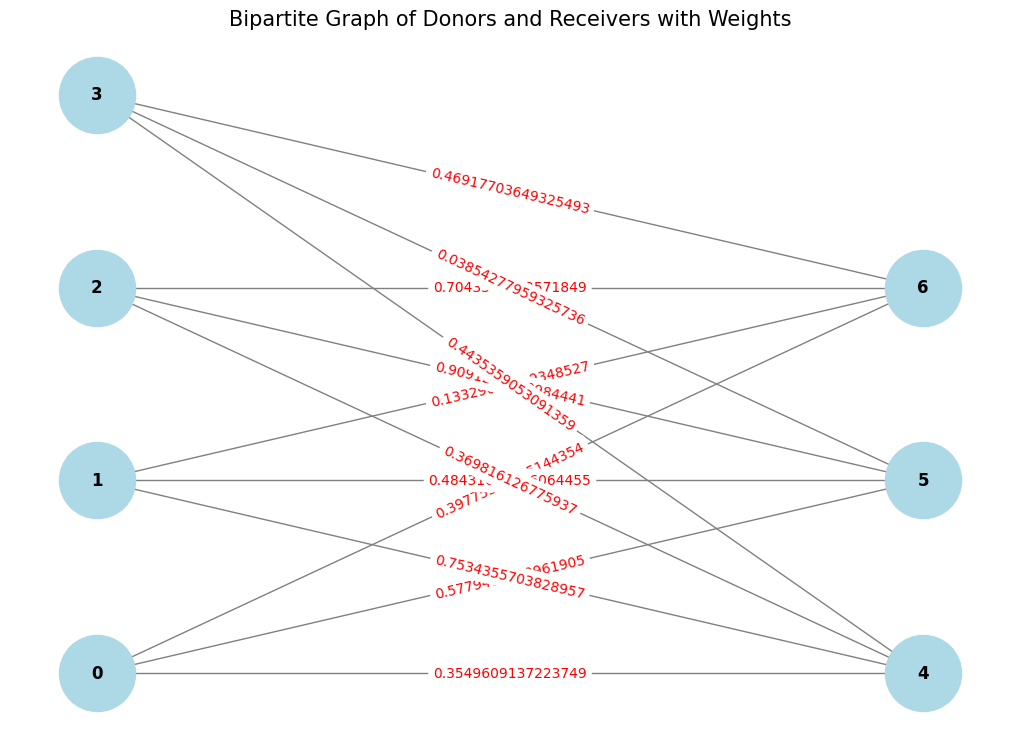

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from itertools import combinations
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, Binary, maximize
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

print("Initializing graph...")
num_donors = 4
num_receivers = 3

donors = list(range(num_donors))  # [0, 1, 2, 3]
receivers = list(range(num_donors, num_donors + num_receivers))  # [4, 5, 6]

compatibility = {
    (0, 4): True,
    (0, 5): True,
    (0, 6): True,
    (1, 4): True,
    (1, 5): True,
    (1, 6): True,
    (2, 4): True,
    (2, 5): True,
    (2, 6): True,
    (3, 4): True,
    (3, 5): True,
    (3, 6): True,
}

print("Creating bipartite graph...")
B = nx.Graph()
B.add_nodes_from(donors, bipartite=0)
B.add_nodes_from(receivers, bipartite=1)

for donor, receiver in compatibility:
    if compatibility[(donor, receiver)]:
        B.add_edge(donor, receiver)

print("Assigning positions to nodes...")
pos = {}
for i, donor in enumerate(donors):
    pos[donor] = (-1, i)
for i, receiver in enumerate(receivers):
    pos[receiver] = (1, i)

print("Assigning weights to edges...")
for (u, v) in B.edges():
    w = random.uniform(0, 1)
    B.edges[u, v]['weight'] = w

print("Drawing the initial graph...")
plt.figure(figsize=(10, 7))
edge_labels = nx.get_edge_attributes(B, 'weight')
nx.draw(B, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=12, font_weight='bold')
nx.draw_networkx_edge_labels(B, pos, edge_labels=edge_labels, font_color='red')
plt.title("Bipartite Graph of Donors and Receivers with Weights", size=15)
plt.show()



Setting up the Aer simulator...
Optimizing using COBYLA...
Iteration 1...
Evaluating cost function for params = [-0.4349417  -1.62834574  2.82548653  3.05872387 -2.62367921  0.4069232
 -3.00947198  0.24262236  0.21228217 -0.30849984 -2.04295577 -2.62378075
  1.3452184   0.44270059 -1.43885485  1.8760136 ]...
Creating QAOA circuit with params = [-0.4349417  -1.62834574  2.82548653  3.05872387 -2.62367921  0.4069232
 -3.00947198  0.24262236  0.21228217 -0.30849984 -2.04295577 -2.62378075
  1.3452184   0.44270059 -1.43885485  1.8760136 ]...
Applying Hadamard gates for initialization...
Applying cost Hamiltonian with gamma = -0.43494170080440764...
Applying mixer Hamiltonian with beta = -1.6283457422310048...
Applying cost Hamiltonian with gamma = 2.8254865332763686...
Applying mixer Hamiltonian with beta = 3.0587238668540273...
Applying cost Hamiltonian with gamma = -2.623679209400613...
Applying mixer Hamiltonian with beta = 0.40692320229866397...
Applying cost Hamiltonian with gamma = -

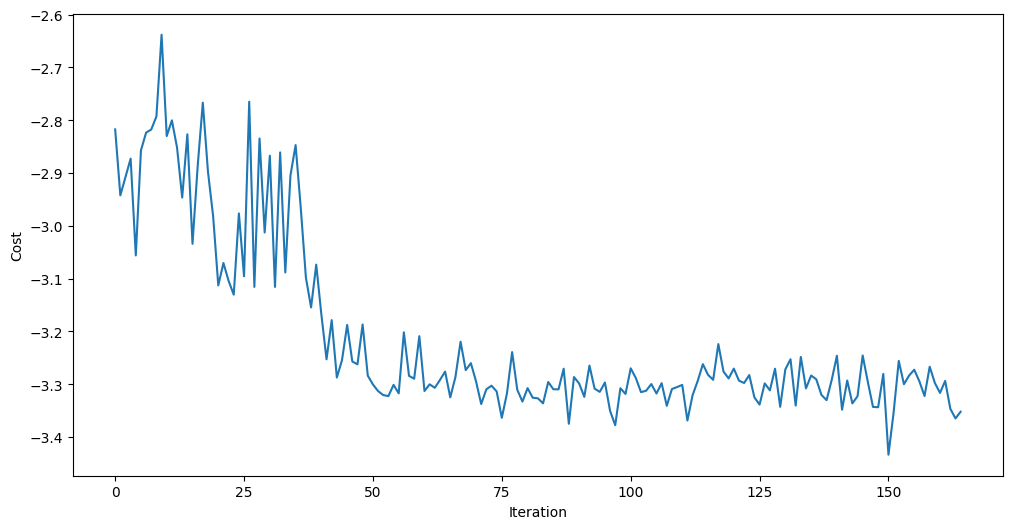

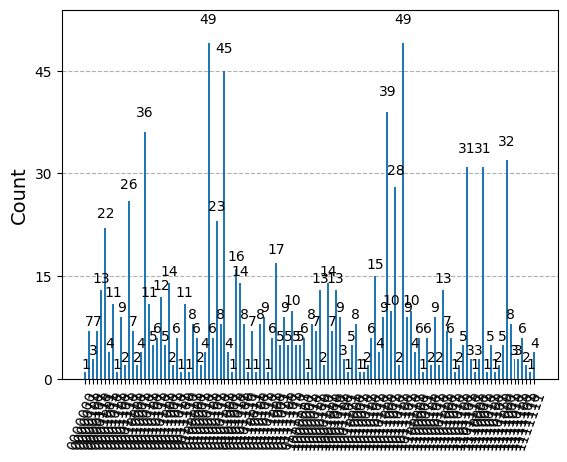

In [5]:
print("Setting up the Aer simulator...")
aer_sim = AerSimulator(max_parallel_threads=10)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01, 1), ['u3'])

depth = 8
rep = 1000
qubits = list(range(num_donors + num_receivers))

def initialization(qc, qubits):
    print("Applying Hadamard gates for initialization...")
    for q in qubits:
        qc.h(q)

def cost_unitary(qc, qubits, gamma):
    print(f"Applying cost Hamiltonian with gamma = {gamma}...")
    for i, j in B.edges():
        qc.cx(qubits[i], qubits[j])
        qc.rz(2 * gamma * B.edges[i, j]['weight'], qubits[j])
        qc.cx(qubits[i], qubits[j])

def mixer_unitary(qc, qubits, beta):
    print(f"Applying mixer Hamiltonian with beta = {beta}...")
    for q in qubits:
        qc.rx(2 * beta, q)

def create_circuit(params):
    print(f"Creating QAOA circuit with params = {params}...")
    gammas = [j for i, j in enumerate(params) if i % 2 == 0]
    betas = [j for i, j in enumerate(params) if i % 2 == 1]

    qc = QuantumCircuit(num_donors + num_receivers)
    initialization(qc, qubits)

    for d in range(depth):
        cost_unitary(qc, qubits, gammas[d])
        mixer_unitary(qc, qubits, betas[d])

    qc.measure_all()
    return qc

objective_func_vals = []
def cost_function(params):
    print(f"Evaluating cost function for params = {params}...")
    qc = create_circuit(params)
    transpiled_qc = transpile(qc, backend=aer_sim)
    job = aer_sim.run(transpiled_qc, shots=rep, noise_model=noise_model)
    result = job.result()
    counts = result.get_counts()
    print(f"Counts: {counts}")

    total_cost = 0
    for bitstring, count in counts.items():
        bit_list = [int(bit) for bit in bitstring]
        for i, j in B.edges():
            total_cost += B.edges[i, j]['weight'] * 0.5 * ((1 - 2 * bit_list[i]) * (1 - 2 * bit_list[j]) - 1) * count
    total_cost = total_cost / rep
    objective_func_vals.append(total_cost)
    print(f"Total cost: {total_cost}")
    return total_cost

print("Optimizing using COBYLA...")
optimal_params = None
optimal_val = np.inf

for i in range(1):
    print(f"Iteration {i+1}...")
    init = np.random.uniform(-np.pi, np.pi, 2 * depth)
    res = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter': 200})
    print(f"Result: {res}")
    if res.fun < optimal_val:
        optimal_params = res.x
        optimal_val = res.fun

print(f"Optimal params: {optimal_params}")
print(f"Optimal value: {optimal_val}")

print("Running final circuit with optimal parameters...")
qc = create_circuit(optimal_params)
transpiled_circuit = transpile(qc, backend=aer_sim)
job = aer_sim.run(transpiled_circuit, shots=rep, noise_model=noise_model)
result = job.result()
counts = result.get_counts()
print(counts)
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()
plot_histogram(counts)



In [1]:
print("Extracting qubit locations with output of 1...")
quantum_preds = []
for bitstring in counts:
    temp = []
    for pos, bit in enumerate(bitstring):
        if bit == '1':
            temp.append(pos)
    quantum_preds.append(temp)
print(f"Quantum predictions: {quantum_preds}")

print("Calculating classical cuts for comparison...")
sub_lists = []
for i in range(num_donors + num_receivers + 1):
    temp = [list(x) for x in combinations(B.nodes(), i)]
    sub_lists.extend(temp)

cut_classic = []
for sub_list in sub_lists:
    cut_classic.append(nx.algorithms.cuts.cut_size(B, sub_list, weight='weight'))

print("Calculating quantum cuts...")
cut_quantum = []
for cut in quantum_preds:
    cut_quantum.append(nx.algorithms.cuts.cut_size(B, cut, weight='weight'))
    print(f"Quantum cuts: {cut_quantum}")

print(f"Quantum mean cut: {np.max(cut_quantum)}")
print(f"Max classical cut: {np.max(cut_classic)}")
print(f"Ratio: {np.max(cut_quantum) / np.max(cut_classic)}")

def bitstring_to_edges(bitstring):
    print(f"Converting bitstring {bitstring} to edges...")
    selected_edges = []
    for idx, bit in enumerate(bitstring):
        if bit == '1':
            selected_edges.append(list(B.edges())[idx])
    return selected_edges

def best_matching_edges(edges):
    print(f"Selecting best matching edges from {edges}...")
    matched_nodes = set()
    best_edges = []

    sorted_edges = sorted(edges, key=lambda x: B.edges[x]['weight'], reverse=True)
    for edge in sorted_edges:
        u, v = edge
        if u not in matched_nodes and v not in matched_nodes:
            best_edges.append(edge)
            matched_nodes.add(u)
            matched_nodes.add(v)
    
    print(f"Best matching edges: {best_edges}")
    return best_edges

for bitstring in counts:
    print(f"Processing bitstring: {bitstring}")
    selected_edges = bitstring_to_edges(bitstring)
    best_edges = best_matching_edges(selected_edges)

    matched_nodes = {n for edge in best_edges for n in edge}
    node_colors = ['red' if node in matched_nodes else 'lightblue' for node in B.nodes()]
    
    print(f"Node positions: {pos}")
    print(f"Node colors: {node_colors}")
    plt.plot(objective_func_vals)
    plt.figure(figsize=(10,7))

Extracting qubit locations with output of 1...


NameError: name 'counts' is not defined